# Image Segmentation - Semantic Segmentation of Pets Images with UNET - Cat and Dog Breeds - Designing UNET with Transfer Learning using MobileNet as the Encoder

37 category pet dataset with roughly 200 images for each class. 

The images have a large variations in scale, pose and lighting. 

All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

This tutorial focuses on the task of image segmentation, using a modified [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-7289_fpn
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-7289_fpn
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a54b67c7f22c200acddf2cc7940aa7d9a76db0a0_-cp36-none-any.whl size=90051 sha256=1b68783a8078b1dcf138648afba9105fee2e1e7ea6e68e930f26ae3d75db01ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-hhxtcd0f/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3.1.0, which is why this particular version is used.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.1.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteUSO2FO/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteUSO2FO/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


The following code performs a simple augmentation of flipping an image. In addition,  image is normalized to [0,1].

Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. 

For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # Data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

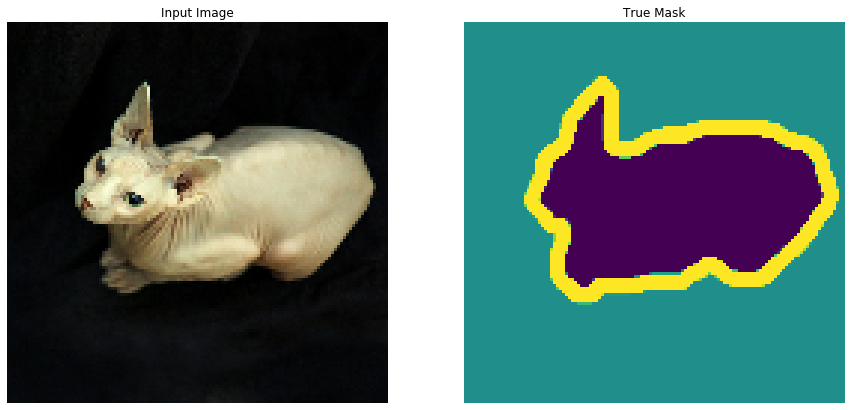

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the Model

The model being used here is a modified U-Net. 

A U-Net consists of an Encoder (downsampler) and Decoder (upsampler). 

In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. 

Thus, **the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used**.

The **decoder will be a upsample block implemented as a function**. 

The reason to output three channels is because there are three possible labels for each pixel. 

Think of this as multi-classification where each pixel is being classified into three classes.


In [ ]:
OUTPUT_CHANNELS = 3

## Designing the Encoder

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). 

The encoder consists of specific outputs from intermediate layers in the model. 

Note that the encoder will not be trained during the training process.

### Lets Check the Original MobileNet Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2()
base_model.summary()

14540800/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

However, in our case we want to use the MobileNet model as a feature extractor (in the Encoder phase of UNET).

Therefore, we drop the last Dense layers from the original model.
We do so, by loading the model and setting the **include_top** parameter to False.

Also, note that the original MobileNet was trained on 224x224x3 dimensional images.

In our case, the input images have dimension 128x128x3. Subsequently, there will be dimension reduction as we apply convolution and maxpooling.

Verify and confirm that all the 16 blocks of the original MobileNet are kept in our encoder, we have just dropped the last dense layers (with Logits).



In [ ]:
## ENCODER 

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
# Outputs from the following layers of the MobileNet will be used as the output of the Encoder
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model - define the Encoder
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# We set ths encoder not trainable (pre-trained)
down_stack.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Designing an Upsample Block for the Decoder

This block is simply a series of upsample operations implemented in the following function. 
Here, we apply Transposed Convolution to upsample the dimension of the images.


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Now we build a set of Sequential layers and store the outputs of each layer in a list.

This list contains a list of Sequential layers.

In [ ]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


## Define the UNET Model

Now we will use the Encoder and a Decoder to build the UNET model.
We Build the Decoder module of UNET by using the Upsampling blocks and applying concatenation of the outputs from the Upsample blocks with that of the encoder in the corresponding layers.

UNET is formed by appending the Decoder at the end of the Encoder and finally applying a final TransposedConvolution layer at the end of the network with 3 convolution filters and a softmax activation.


In [ ]:
def unet_model(output_channels):

  # This is the last layer of the model
  # softmax gives probabilities of the output categories
  # 3 filters are representing the probabilities for the 3 categories - object, border and the background
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Apply Encoder
  # Downsampling through the model
  skips = down_stack(x)  # skips is 64x64, 32x32, 16x16, 8x8, 4x4
  x = skips[-1] # x is 4x4
  skips = reversed(skips[:-1]) # 8x8, 16x16, 32x32, 64x64

  # Apply Decoder = Upsample + Concatenation (skip connections)
  # Upsampling and establishing the skip connections
  # skips    :  8x8, 16x16, 32x32, 64x64
  # up_stack :  8x8, 16x16, 32x32, 64x64
  # x        : 4x4
  for up, skip in zip(up_stack, skips):
    x = up(x)  # x is now 8x8, at the next iteration it will be 16x16 and so on...
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])  # now both x and skip are 8x8 so they can be concatenated
                           # at the next iteration it will be 16x16 and so on...
  # After the final iteration, at this step, x is 64x64

  # This final TransposedConvolution will make the output image 128x128
  # The 3 channels of the image corresponds to the probabilities of the three output categories
  # object, border and background
  x = last(x) 

  return tf.keras.Model(inputs=inputs, outputs=x) 
  

## Train the model
Now, all that is left to do is to compile and train the model. 
The loss being used here is losses.sparse_categorical_crossentropy. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. 
In the true segmentation mask, each pixel has either a {0,1,2}. 

The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.sparse_categorical_crossentropy is the recommended loss for such a scenario.
Using the output of the network, the label assigned to the pixel is the channel with the highest value. 


In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

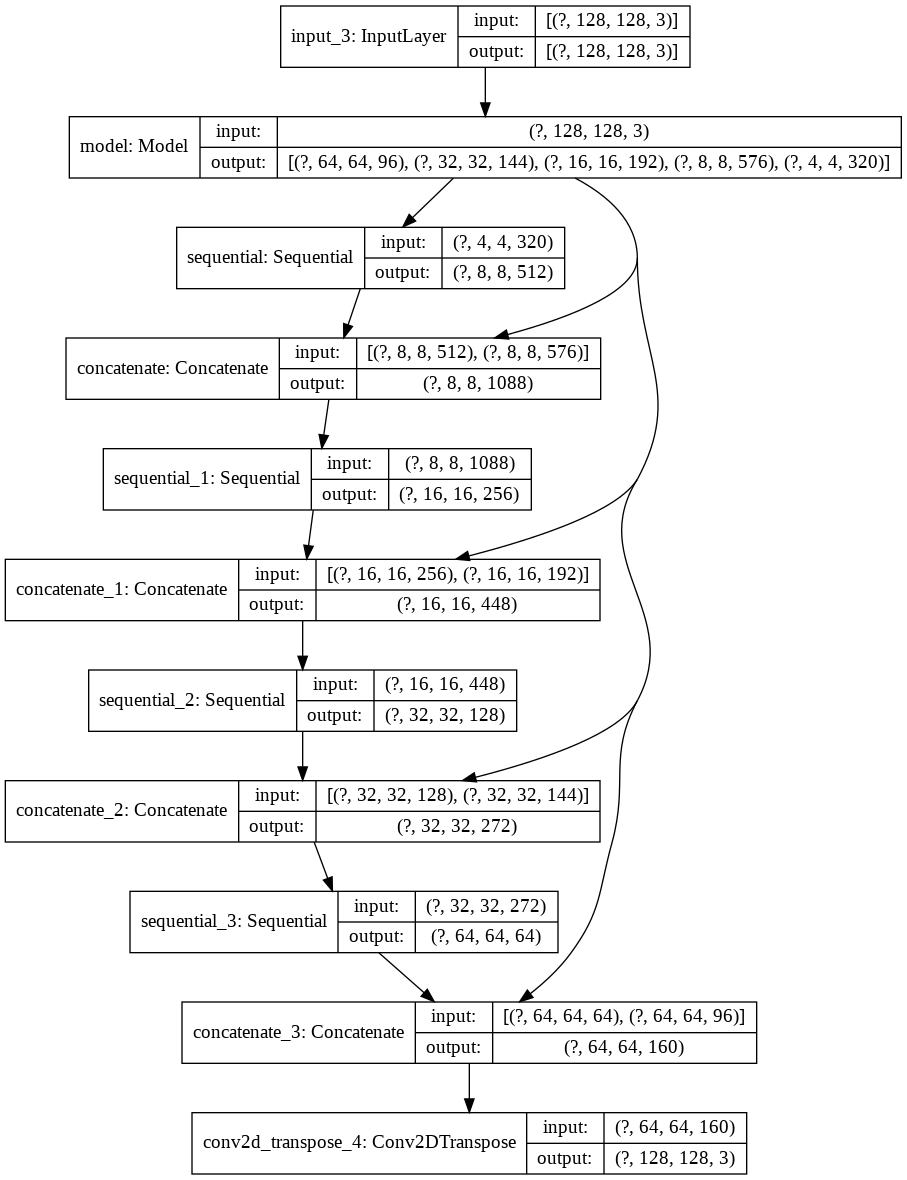

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Each channel is trying to learn to predict a class. 

Using the output of the network, the label assigned to the pixel is the channel with the highest value. 

This is what the create_mask function is doing.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Let's try out the model to see what it predicts before training.

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

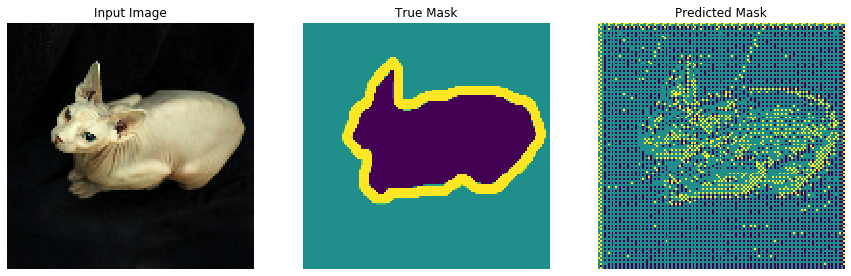

In [ ]:
show_predictions()

### Define a Custom Callback

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Train the Model


Run the next cell and watch the predicted output at the end of every epoch during training.

See how the predicted output is becoming more and more accurate as we train the network for longer.

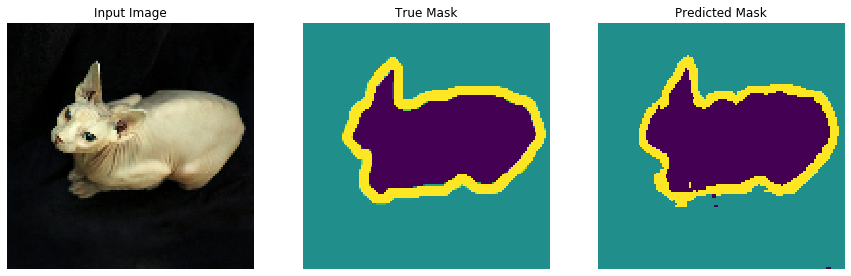


Sample Prediction after epoch 20

57/57 [==============================] - 9s 154ms/step - loss: 0.1466 - accuracy: 0.9337 - val_loss: 0.3490 - val_accuracy: 0.8779


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

### Plot Model Loss w.r.t the Training and the Validation Data

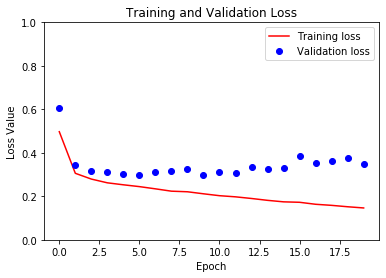

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make Predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

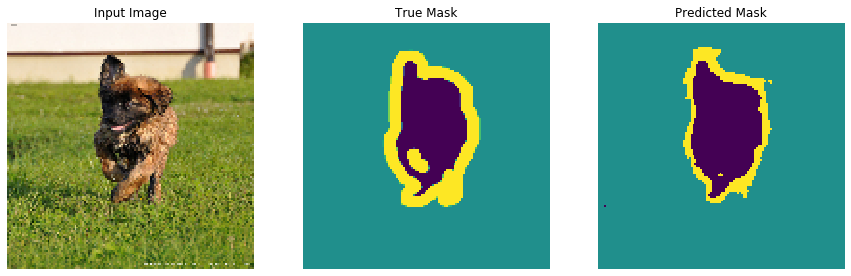

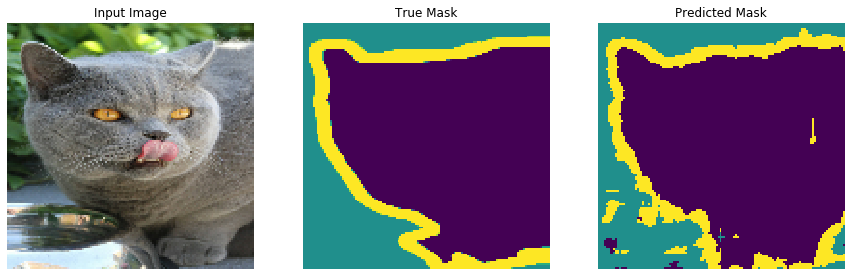

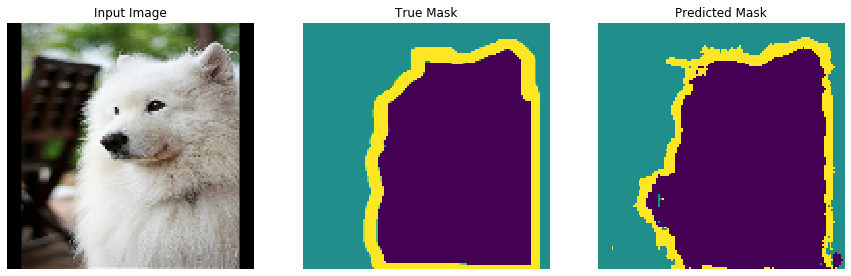

In [ ]:
show_predictions(test_dataset, 3)